In [1]:
# numerics
import numpy as np

# data reading
import pandas as pd

# plotting
import matplotlib.pyplot as plt

import emd

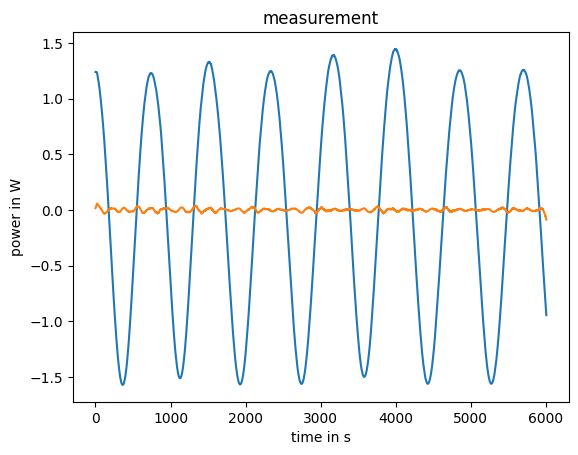

In [16]:
filename = "2024_11_22_altu_hema_egdma"

file_path = f"data/{filename}.csv"

# Read the CSV, skipping rows until the data table starts
df = pd.read_csv(file_path, sep=';', skiprows=14, decimal=',')
df.columns = df.columns.str.strip()

# Strip whitespace and convert to datetime objects
df['Time'] = pd.to_datetime(df['Time of day (hh:mm:ss)'].str.strip(), format='%H:%M:%S.%f')

# Calculate time since the start
start_time = df['Time'].iloc[0]
df['Time Since Start (seconds)'] = (df['Time'] - start_time).dt.total_seconds()

# Save as jnp arrays
time_points_measured = np.asarray(df['Time Since Start (seconds)'])
power_measured = np.asarray(df["Power (W)"])

# normalize the power measurements
power_measured = (power_measured - np.mean(power_measured)) / np.std(power_measured)

# Display the result
plt.plot(time_points_measured, power_measured)
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("measurement")

# peak_locs, peak_mags = emd.sift.get_padded_extrema(power_measured, pad_width=0, mode='peaks')
# plt.plot(peak_locs, peak_mags, 'ro')

import pywt

wavelet_type = 'db6'

# Wavelet transform
coeffs_power = pywt.wavedec(power_measured, wavelet_type, level = 7)
 
# Inverse wavelet transform
new_coeffs_power = coeffs_power.copy()
new_coeffs_power[0] = 0*new_coeffs_power[0]
 
# Inverse wavelet transform
new_power = pywt.waverec(new_coeffs_power, wavelet_type)

plt.plot(time_points_measured, new_power[:-1])


(6009, 5)


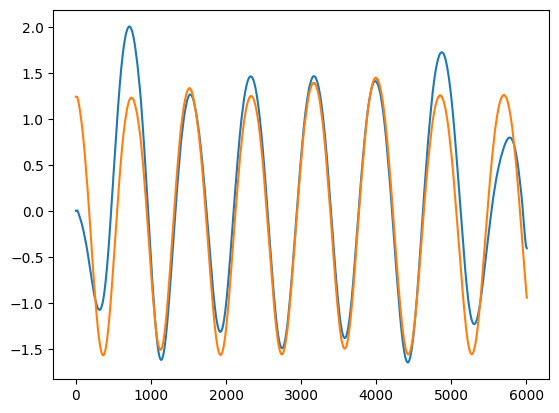

In [3]:
imf = emd.sift.sift(power_measured, max_imfs=10)
print(imf.shape)

# plt.plot(time_points_measured, power_measured, label="original")
plt.plot(time_points_measured, imf[:, 2], label="reconstructed")
plt.plot(time_points_measured, power_measured)

<Axes: title={'center': 'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

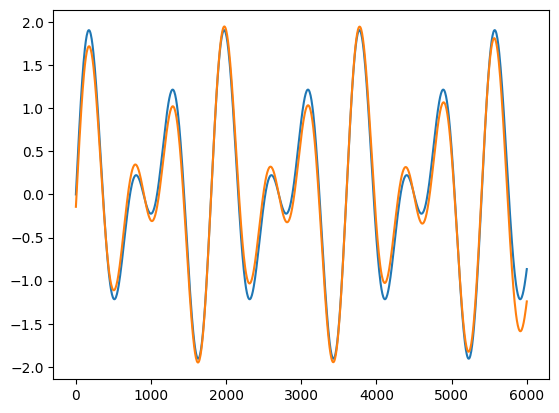

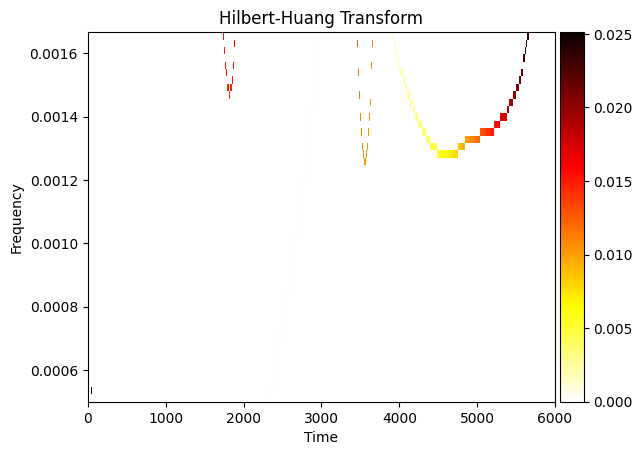

In [19]:
time_points_measured = np.linspace(0, 6000, 1000)
power_measured = np.sin(2 * np.pi / 900 * time_points_measured) + np.sin(2 * np.pi / 600 * time_points_measured)
plt.plot(time_points_measured, power_measured)
imf = emd.sift.sift(power_measured, max_imfs=2)
plt.plot(time_points_measured, imf[:, 0], label="reconstructed")
IP, IF, IA = emd.spectra.frequency_transform(imf, 1, 'hilbert')
f, hht = emd.spectra.hilberthuang(IF, IA, (1/2000, 1/600, 50), sum_time=False)
emd.plotting.plot_hilberthuang(hht, time_points_measured, f)

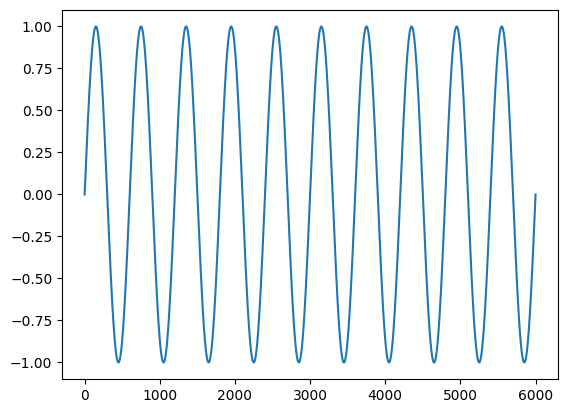

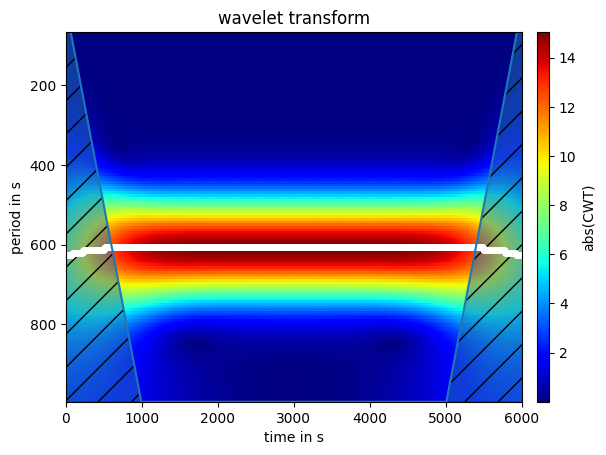

In [22]:
# test of wavelet analysis

from reflax.data_analysis.scaleogram import cws


def plot_scaleogram(ax, time_points, signal, title, ylabel = "period in s", xlabel = "time in s", cbarlabel = "abs(CWT)", yscale = "linear", cscale = "linear", scales = np.arange(10, 1000, 10), clim = None, coi = True): # scales = np.arange(100, 2200, 20)
    cws(time = time_points, signal = signal, ax = ax, scales = scales, wavelet="cmor1-1.5", coikw={'alpha':0.5,'hatch':'/'}, ylabel = ylabel, xlabel = xlabel, title = title, cscale = cscale, yscale = yscale, cbarlabel = cbarlabel, clim = clim, coi=coi)

time = np.linspace(0, 6000, 6001)
period = 600
signal = np.sin(2 * np.pi / period * time)

plt.plot(time, signal)

fig, ax = plt.subplots()
plot_scaleogram(ax, time, signal, "wavelet transform", scales = np.arange(100, 1500, 10), coi=True)